<a href="https://colab.research.google.com/github/MinhVuong2000/Data-Science/blob/master/%08Melnourne_House_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Using [data](https://www.kaggle.com/anthonypino/melbourne-housing-market) create a model Linear Regression to predict a house's value.
Report include:
1. Examine and explore data
2. Apply model with holdout and cross validation when:
  1. using PCA
  2. using PCA
3. Visualize the residue and homoscedasticity 
4. Tune the model (if can)
5. Conclusion for summary


# Explore Data

## Get data from kaggle

In [ ]:
!import file from kaggle
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anthonypino/melbourne-housing-market
!ls

/bin/bash: import: command not found


Saving kaggle.json to kaggle (1).json
melbourne-housing-market.zip: Skipping, found more recently modified local copy (use --force to force download)
 files		    kaggle.json			   sample_data
'kaggle (1).json'   melbourne-housing-market.zip


In [ ]:
#upzip downloaded files from kaggle
import zipfile
zip_ref = zipfile.ZipFile('melbourne-housing-market.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
!ls files

MELBOURNE_HOUSE_PRICES_LESS.csv  Melbourne_housing_FULL.csv


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("files/MELBOURNE_HOUSE_PRICES_LESS.csv")
data.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


## Exploring Data

In [ ]:
#justify data: only get some features, include: address, rooms, price, sellerG, Date, Distance to explore
data = data[['Regionname','Address','Rooms','Price','Date','SellerG','Distance','Propertycount']]
#change type of columns Date from string to datetime
data["Date"] = pd.to_datetime(data["Date"],dayfirst=True)
data.head(5)

,Regionname,Address,Rooms,Price,Date,SellerG,Distance,Propertycount
0,Northern Metropolitan,49 Lithgow St,3,1490000.0,2017-04-01,Jellis,3.0,4019
1,Northern Metropolitan,59A Turner St,3,1220000.0,2017-04-01,Marshall,3.0,4019
2,Northern Metropolitan,119B Yarra St,3,1420000.0,2017-04-01,Nelson,3.0,4019
3,Western Metropolitan,68 Vida St,3,1515000.0,2017-04-01,Barry,7.5,1543
4,Western Metropolitan,92 Clydesdale Rd,2,670000.0,2017-04-01,Nelson,10.4,3464


In [ ]:
print(data.shape)
print(data.info())

(63023, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Regionname     63023 non-null  object        
 1   Address        63023 non-null  object        
 2   Rooms          63023 non-null  int64         
 3   Price          48433 non-null  float64       
 4   Date           63023 non-null  datetime64[ns]
 5   SellerG        63023 non-null  object        
 6   Distance       63023 non-null  float64       
 7   Propertycount  63023 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.8+ MB
None


Having non-value in columns Price

In [ ]:
#drop nan
data = data.dropna(axis='rows')
print(data.shape)
data.describe(include=['object', 'float', 'int'])

(48433, 8)


,Regionname,Address,Rooms,Price,SellerG,Distance,Propertycount
count,48433,48433,48433.000000,4.843300e+04,48433,48433.000000,48433.000000
unique,8,44739,NaN,NaN,422,NaN,NaN
top,Northern Metropolitan,14 Moray St,NaN,NaN,Barry,NaN,NaN
freq,13598,7,NaN,NaN,4818,NaN,NaN
mean,NaN,NaN,3.071666,9.978982e+05,NaN,12.702761,7566.399913
std,NaN,NaN,0.944708,5.934989e+05,NaN,7.550030,4457.405884
min,NaN,NaN,1.000000,8.500000e+04,NaN,0.000000,39.000000
25%,NaN,NaN,2.000000,6.200000e+05,NaN,7.000000,4280.000000
50%,NaN,NaN,3.000000,8.300000e+05,NaN,11.700000,6567.000000
75%,NaN,NaN,4.000000,1.220000e+06,NaN,16.700000,10412.000000


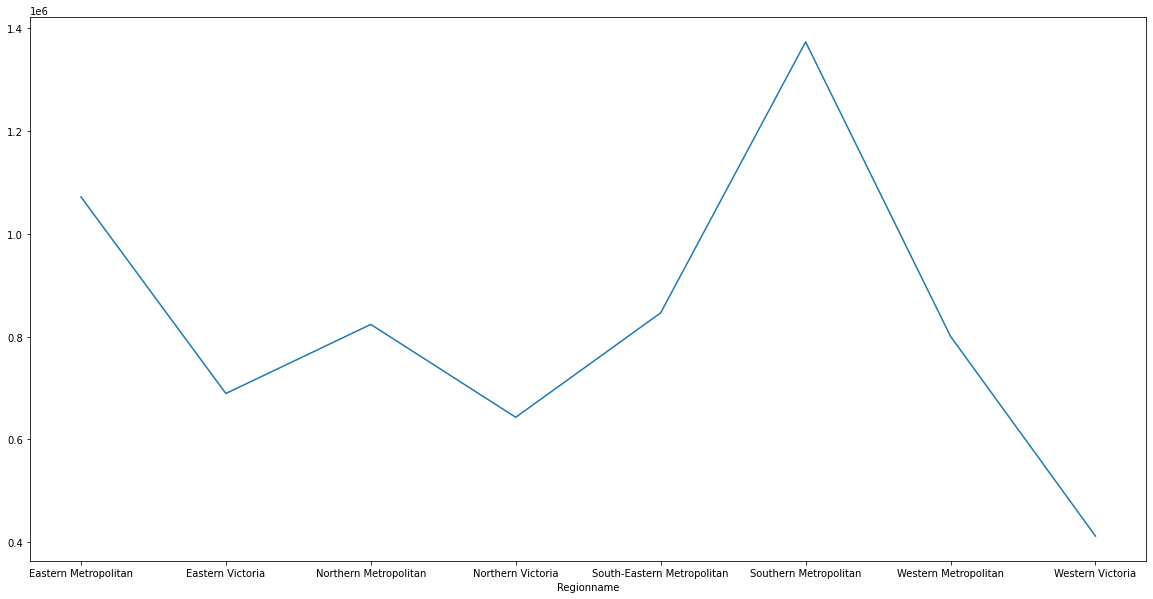

In [ ]:
#chart about amount of house's value 
data.groupby('Regionname')['Price'].mean().plot(kind='line', figsize=(20,10))
plt.show()

From this line chart, Southern Metropolitan has the highest price mean and the lowest one is Western Victoria. The others don't quite different.

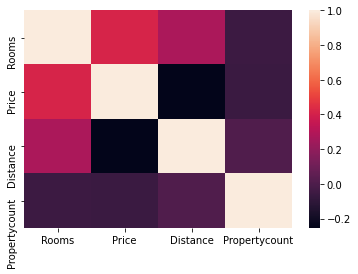

In [ ]:
#correlation
corr = data.corr()
sns.heatmap(corr)

You can see that, price is influenced highly by number of rooms and inverse ratio with Distance, Property Count

### Analyst Impact
  Now, we focus on considering whether distance have the impact to price

In [ ]:
print('maximum Distance: ', max(data.Distance))
print('minimum Distance:',min(data.Distance))

maximum Distance:  55.8
minimum Distance: 0.0


From min max of Distance, I divide Distance into 4 parts, include 0-5, 5-10, 10-20, 20-40, and >40

We visualize price in each part

In [ ]:
#create dictionary Distance
Dic={'5':[],'10':[],'20':[],'40':[],'others':[]}
for i in data.index.tolist():
  if (data.Distance[i]<=5):
    Dic['5'].append(data.Price[i])
  elif (data.Distance[i]<=10):
    Dic['10'].append(data.Price[i])
  elif (data.Distance[i]<=20):
    Dic['20'].append(data.Price[i])
  elif (data.Distance[i]<=40):
    Dic['40'].append(data.Price[i])
  else:
    Dic['others'].append(data.Price[i])

<BarContainer object of 5 artists>

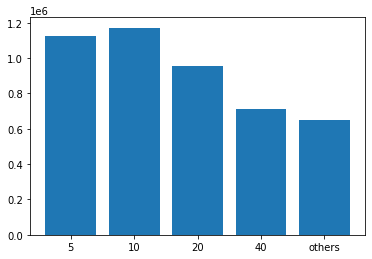

In [ ]:
#visualize
meanDic = []
for key in Dic:
    meanDic.append(np.mean(Dic[key]))
plt.bar(Dic.keys(), meanDic)

Can see that, distance between 5 and 10 having the highest price, and more far less cost

In [ ]:
pvalue = f_oneway(*(Dic[t] for t in list(Dic))).pvalue
if (pvalue<0.05):
  print("p-value:{}, so Distance have impact to Price".format(pvalue))
else:
  print("p-value:{}, so don't enought to  reject Distance doesn't have impact to Price".format(pvalue))


p-value:0.0, so Distance have impact to Price


## Apply Model Linear Regression
#### Now I will predict price base on Distance, Rooms and PropertyCount

In [ ]:
#make model
linreg = LinearRegression()

In [ ]:
# create x and y
x=data.drop(['Regionname', 'Address','SellerG','Date','Price'],axis=1)
y=data.Price
#x= data.Distance
"""x = data[['Distance', 'Price']]
a = StandardScaler().fit(x.Distance.to_numpy().reshape(-1,1)).transform(x.Distance.to_numpy().reshape(-1,1))
y=pd.DataFrame(data.Price)
y = StandardScaler().fit(x.Price.to_numpy().reshape(-1,1)).transform(x.Price.to_numpy().reshape(-1,1))
plt.figure(figsize=(20,10))
plt.scatter(a,y)"""

"x = data[['Distance', 'Price']]\na = StandardScaler().fit(x.Distance.to_numpy().reshape(-1,1)).transform(x.Distance.to_numpy().reshape(-1,1))\ny=pd.DataFrame(data.Price)\ny = StandardScaler().fit(x.Price.to_numpy().reshape(-1,1)).transform(x.Price.to_numpy().reshape(-1,1))\nplt.figure(figsize=(20,10))\nplt.scatter(a,y)"

##Not using PCA

In [ ]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)
# the test set will be 20% of the whole data set

In [ ]:
#fit model
linreg.fit(x_train, y_train)
#print 
print('intercept =',linreg.intercept_)
print('coef =', linreg.coef_)

intercept = 404172.6007019655
coef = [ 3.33303359e+05 -3.16061099e+04 -3.86071096e+00]


In [ ]:
predictions = linreg.predict(x_test)
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MSE: 250851281409.15134
RMSE: 500850.5579603075


Can see that MSE is quite high, so model is not good in this data

In [ ]:
"""print(x_test.shape,y_test.shape)
plt.scatter(x_test, y_test, color="black")
plt.plot(x_test,predictions)"""

'print(x_test.shape,y_test.shape)\nplt.scatter(x_test, y_test, color="black")\nplt.plot(x_test,predictions)'

#### Residue

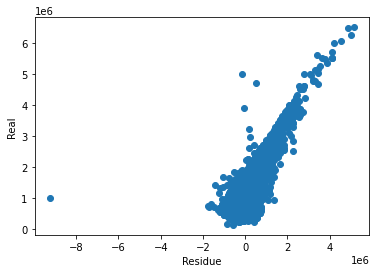

In [ ]:
residual = (y_test - predictions)
plt.scatter(residual,y_test)
plt.xlabel('Residue')
plt.ylabel('Real')
plt.show()

The residual is near by 0, so don't having error between real and predict.
In this divide, it make the result which is quite good

#### Cross-Validation

score cross validation is:  [0.30779862 0.33108619 0.32853542 0.15826204 0.33327621]


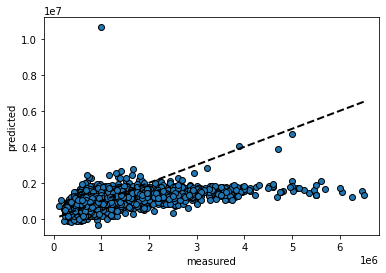

In [ ]:
print("score cross validation is: ", cross_val_score(linreg,x_test,y_test,cv=5))
predicted = cross_val_predict(linreg,x_test,y_test,cv=5)
fig, ax = plt.subplots()
ax.scatter(y_test,predicted,edgecolors=(0,0,0))
ax.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--',lw=2)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

So, score cross validation is quite low, it represent that linear regression is not fit with this data.

## Using PCA

In [ ]:
pca = PCA(n_components=3)
pca = pca.fit(x)
x_PCA = pca.transform(x)

In [ ]:
# split data into train and test
xPCA_train, xPCA_test, yPCA_train, yPCA_test = train_test_split(
    x_PCA, y, test_size=0.2)
# the test set will be 20% of the whole data set

In [ ]:
linreg.fit(xPCA_train,yPCA_train)
#print 
print('a0=',linreg.intercept_)
print('a=', linreg.coef_)

a0= 998379.9817970752
a= [-8.30294713e+00 -1.97031216e+04  3.26176741e+05]


In [ ]:
predictionPCA = linreg.predict(xPCA_test)
print('MSE:', metrics.mean_squared_error(yPCA_test, predictionPCA))
print('RMSE:', np.sqrt(metrics.mean_squared_error(yPCA_test, predictionPCA)))

MSE: 238710476902.67462
RMSE: 488580.0619168517


When using PCA, MSE isn't be different from not using PCA, but better a little

### Residue

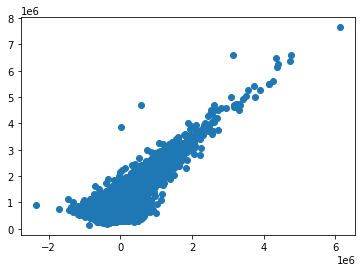

In [ ]:
residualPCA = (yPCA_test - predictionPCA)
plt.scatter(residualPCA,yPCA_test)
plt.show()

Can see that, using PCA, the residual is more converging into 0. That mean that using PCA better

### Cross-Validation

score cross validation is:  [0.33438511 0.32819593 0.35303611 0.31393234 0.29439526]


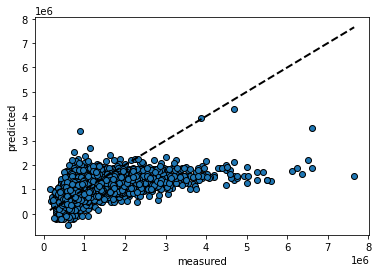

In [ ]:
print("score cross validation is: ", cross_val_score(linreg,xPCA_test,yPCA_test,cv=5))
predictedPCA = cross_val_predict(linreg,xPCA_test,yPCA_test,cv=5)
fig, ax = plt.subplots()
ax.scatter(yPCA_test,predictedPCA,edgecolors=(0,0,0))
ax.plot([yPCA_test.min(), yPCA_test.max()],[yPCA_test.min(), yPCA_test.max()],'k--',lw=2)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

Similar to residual

# Conclusion

Using PCA bring to be efficient to predict. And the result conclude that linear regression don't make to efficient in this case

*  Don't use this model to predict because the accuracy will not be high, so that don't bring benefit